In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest

#1. Introduction to Time Series

Time series components (assumed):

* y = Trend + Seasonal + Cyclical + Irregular (Additive)
* y = Trend * Seasonal * Cyclical * Irregular (Multiplicative)

**Trend:** Long term change in time series. It has a particular direction.

**Seasonality:** Repeated ups and downs in the signal. Eg: Weather change in summer and winter.

**Cyclical:** Like seasonality but its regularity is not as fixed. Eg: Business Cycles

**Irregular Term:** The unpredictible residual in the time series signal.

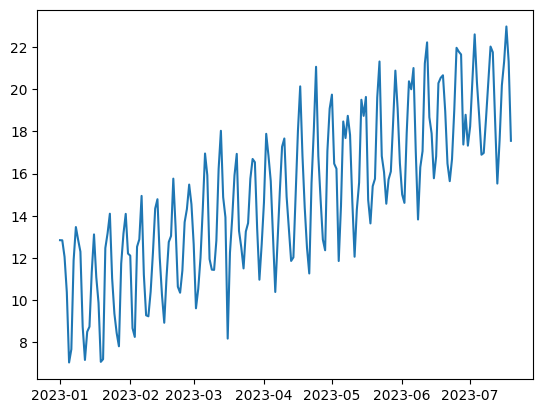

In [ ]:
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', periods=200, freq='D')

#trend component
trend = np.linspace(10, 20, 200)

#seasonality component
seasonality = 3 * np.sin(2 * np.pi * date_range.dayofyear / 7)

#random gaussian noise
noise = np.random.normal(loc=0, scale=1, size=200)

#time series = noise + seasonality + trend
data = trend + seasonality + noise
ts = pd.Series(data, index=date_range)
plt.plot(ts)

Why time series are different?

Most machine learning problems predict values inside the range of known data. But time series prediction means guessing what will happen in the future, beyond the data we have (called **extrapolation**). Therefore, as the model predicts further into the future, its accuracy tends to decrease. We use different methods (like rolling window origin) to combat this problem.

#2. Filling the Missing Values

A time series data doesn't have to be full. Many times it contains empty values. We have several methods for filling these data points.

## 2.1 Forward Fill

$X_t ← X_{t-1}$

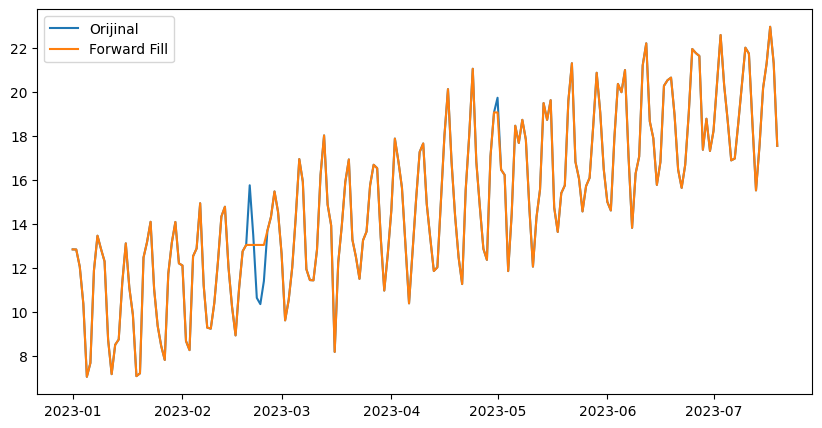

In [ ]:
ts_missing = ts.copy()
ts_missing.iloc[50:55] = np.nan
ts_missing.iloc[120] = np.nan

ts_forward = ts_missing.ffill()
plt.figure(figsize=(10,5))
plt.plot(ts, label='Orijinal')
plt.plot(ts_forward, label='Forward Fill')
plt.legend()

## 2.2. Backward Fill

$X_t ← X_{t+1}$

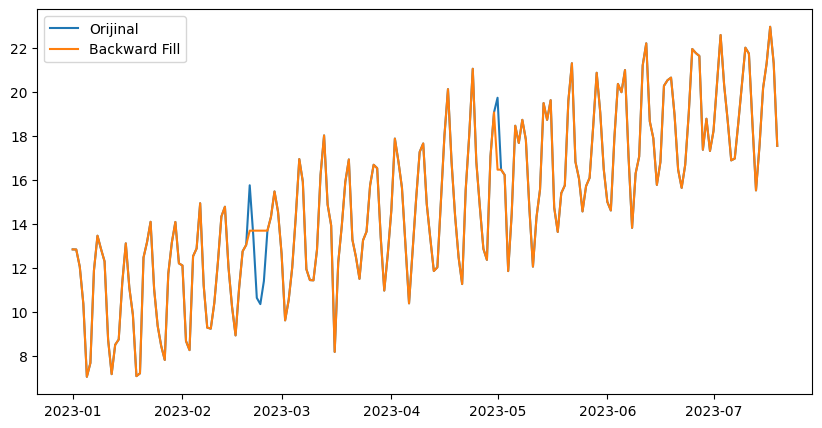

In [ ]:
ts_backward = ts_missing.bfill()
plt.figure(figsize=(10,5))
plt.plot(ts, label='Orijinal')
plt.plot(ts_backward, label='Backward Fill')
plt.legend()

## 2.3. Interpolation

$X_t ← μ(X_{t-y},X_{t+r})$

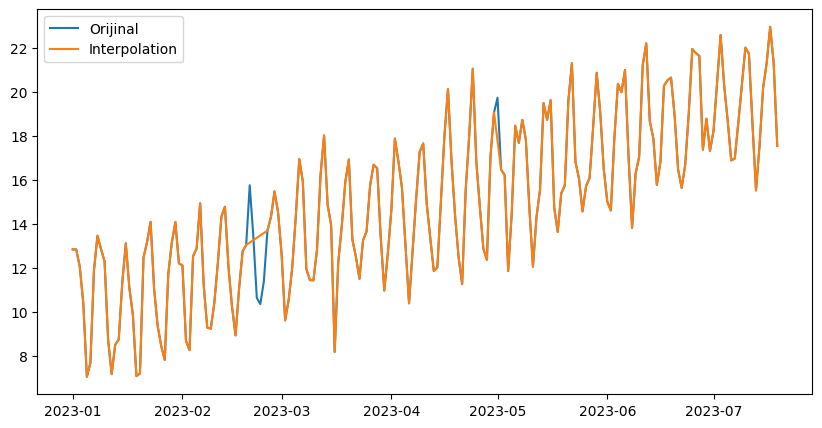

In [ ]:
ts_interpolation = ts_missing.interpolate(method='linear')
plt.figure(figsize=(10,5))
plt.plot(ts, label='Orijinal')
plt.plot(ts_interpolation, label='Interpolation')
plt.legend()
plt.show()

# 3. Decomposing Time Series

The goal is to decompose the time series to its components. It's useful for many operations like anomaly detection.

**Detrending:** Estimate the trend and remove it from the time series. Common methods: "moving averages"  and "LOESS" Regression.

**Deseasonalizing:** Removing seasonal component from the time series. The most common method is to use Fourier Series.

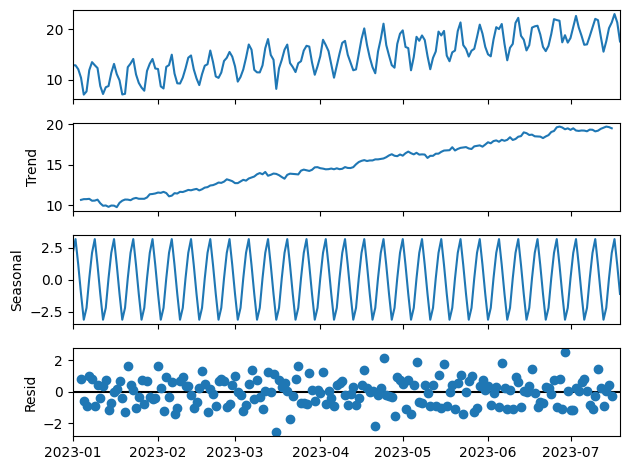

In [ ]:
#synthetic data has a weekly cyclic component
#we used additive formula during dataset generation
res = seasonal_decompose(ts, model='additive', period=7)
res.plot()
plt.show()

# 4. Detecting Outliers

## 4.1. Detecting Outliers Using Gaussian Assumption

Procedure:

* Decompose the time series data.
* On residuals, if $x_i > \mu + 3 \sigma^2$ or $x_i < \mu - 3 \sigma^2$ then label $x_i$ as anomaly.

**Note:** Do not apply this procedure on raw time series data.

**Note:** The sigma multiplier can be arranged depending on the case.

In [ ]:
resid = res.resid
mu_resid = resid.mean()
sigma_resid = resid.std()

outliers = resid[(resid > mu_resid + 3*sigma_resid) | (resid < mu_resid - 3*sigma_resid)]
print(f"Aykırı değer sayısı: {len(outliers)}")
print(outliers)

Aykırı değer sayısı: 0
Series([], Freq: D, Name: resid, dtype: float64)


## 4.2. Detecting Outliers Using IQR

Procedure:

* Decompose the time series data.
* On residuals, if $x_i > Q3 + 1.5 IQR$ or $x_i < Q3 - 1.5 IQR$ then label $x_i$ as anomaly.

**Note:** Do not apply this procedure on raw time series data.

**Note:** The IQR multiplier can be arranged depending on the case.

**Note:** This method is more robust for the dataset having lots of outliers. (Median is more robust compared to the mean)

## 4.3. Isolation Forest

**Note:** The algorithm does not consider time.

In [ ]:
iso = IsolationForest(random_state=42)
iso.fit(np.reshape(ts, (-1, 1)))
preds = iso.predict(np.reshape(ts, (-1, 1)))

anomalies = ts[preds == -1]
print(f"Number of anomalies: {len(anomalies)}")


Number of anomalies: 55


# 5. Treating Outliers

* When the dataset is small, try to understand the cause of the outlier points. It may give useful insights.

* When the dataset is big, it is impossible to inspect. Therefore, replace them automatically with maximum, minimum, 75th percentile. Alternatively, assign them as NaN and use imputation methods.

* Note that with the emergence of deep learning methods, it is not necessary to treat outlier data points.